In [1]:
import camb
import numpy as np
import matplotlib.pyplot as plt
from camb import model
from scipy.interpolate import interp1d
import os 

%matplotlib inline

In [5]:
# Test RUN
H0        = 70
h         = H0/100
Omega_b   = 0.04
Omega_c   = 0.26
w0        = -1.0
wa        = 0.0
LnA_s     = 2.9500 # per sigma8=0.83
A_s       = np.exp(LnA_s)/1.0e10
n_s       = 0.96
m_nu      = 0.0
delta_var = 7
z_arr     = np.linspace(0, 100, 150) 

In [2]:
# LCDM Planck cosmology old run from Pigi
H0        = 67.11
h         = H0/100
Omega_b   = 0.049
Omega_c   = 0.2685
w0        = -1.0
wa        = 0.0
LnA_s     = 3.05850 # per sigma8=0.83
A_s       = np.exp(LnA_s)/1.0e10
n_s       = 0.9624
m_nu      = 0.0
nnu       = 3.046
num_massive_neutrinos = 0
YHe       = 0.24
delta_var = 7
tau       = 0.0925
z_arr     = np.linspace(0, 100, 150) 

print(A_s)
print(Omega_b*h**2)

2.1295589807793417e-09
0.022068385290000003


In [9]:

# Matter power spectrum
pars = camb.CAMBparams()
pars.set_cosmology(H0=H0, ombh2=Omega_b * h**2, omch2=Omega_c * h**2, mnu=m_nu, num_massive_neutrinos=num_massive_neutrinos, nnu=nnu, YHe=YHe, tau=tau)
pars.set_dark_energy(w=w0,wa=wa,dark_energy_model='ppf')
pars.InitPower.set_params(As=A_s, ns=n_s)
pars.set_matter_power(redshifts=z_arr)
pars.NonLinear  = model.NonLinear_none

# Set the calculation of the transfer functions
pars.WantTransfer  = True
pars.Transfer.kmax = 200

# get results
results = camb.get_results(pars)

# Setting values for a PINOCCHIO like Pk
nk   = 503
kmin = 0.108800E-04
kmax = 0.201290E+03

k_arr, _, pk_z = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints=nk, var1=delta_var, var2=delta_var)

# Create readshifts file at which PK and TRASNFER Function are calculated and the realtion with the run name i.e. z=0 --> 000 and so on
if not os.path.exists('CAMB_redshifts'):
    os.makedirs('CAMB_redshifts')

redshift_file_name = f'CAMB_redshifts/redshifts_file.txt'
outputs_index      = [str(i).zfill(3) for i in range(len(z_arr))]
z_arr_values       = [z_arr[i] for i in range(len(z_arr))]

# Concatenate index and z_arr values into a single array
data = np.column_stack((outputs_index, z_arr_values[::-1]))
np.savetxt(redshift_file_name, data , fmt='%s', delimiter=' ')

# Create Camb PK Tables for Pinocchio run
if not os.path.exists('CAMB_PK_Tables_and_Transfer_function'):
    os.makedirs('CAMB_PK_Tables_and_Transfer_function')

# Iterate over each redshift and save corresponding data
for i in range(len(z_arr)):
    file_name          = f'CAMB_PK_Tables_and_Transfer_function/camb_pk_{str(i).zfill(3)}.dat'
    np.savetxt(file_name, np.column_stack((k_arr , pk_z[::-1][i])), delimiter=' ')
  
# Extract transfer function at the same wavenumbers and all redshifts
transfer_data = results.get_matter_transfer_data()

# Create interpolators for transfer function at the redshifts corresponding to matter power spectrum
transfer_interpolators_cdm, transfer_interpolators_bar, transfer_interpolators_phot, transfer_interpolators_neutrino, transfer_interpolators_nu, transfer_interpolators_tot = [] , [], [], [], [], []

for i in range(len(z_arr)):
    # Get transfer function data for current redshift
    transfer_z_k         = transfer_data.transfer_z('k/h', z_index=i)
    transfer_z_delta_cdm = transfer_data.transfer_z('delta_cdm', z_index=i)
    transfer_z_phot      = transfer_data.transfer_z('delta_photon', z_index=i)
    transfer_z_neutrino  = transfer_data.transfer_z('delta_neutrino', z_index=i) # mass less neutrino
    transfer_z_nu        = transfer_data.transfer_z('delta_nu', z_index=i) # massive neutrino
    transfer_z_delta_bar = transfer_data.transfer_z('delta_baryon', z_index=i)
    transfer_z_delta_tot = transfer_data.transfer_z('delta_tot', z_index=i)
    
    # Create interpolator using k/h values and transfer function data
    interpolator_cdm  = interp1d(transfer_z_k, transfer_z_delta_cdm, kind='linear', fill_value='extrapolate')
    interpolator_bar  = interp1d(transfer_z_k, transfer_z_delta_bar, kind='linear', fill_value='extrapolate')
    interpolator_phot = interp1d(transfer_z_k, transfer_z_phot, kind='linear', fill_value='extrapolate')
    interpolator_neu  = interp1d(transfer_z_k, transfer_z_neutrino, kind='linear', fill_value='extrapolate')
    interpolator_nu  = interp1d(transfer_z_k, transfer_z_nu, kind='linear', fill_value='extrapolate')
    interpolator_tot  = interp1d(transfer_z_k, transfer_z_delta_tot, kind='linear', fill_value='extrapolate')
    transfer_interpolators_cdm.append(interpolator_cdm)
    transfer_interpolators_phot.append(interpolator_phot)
    transfer_interpolators_neutrino.append(interpolator_neu)
    transfer_interpolators_nu.append(interpolator_nu)
    transfer_interpolators_bar.append(interpolator_bar)
    transfer_interpolators_tot.append(interpolator_tot)

# Save interpolated transfer function data for each redshift
if not os.path.exists('CAMB_PK_Tables_and_Transfer_function'):
    os.makedirs('CAMB_PK_Tables_and_Transfer_function')

for i in reversed(range(len(z_arr))):
    transfer_interpolated_cdm  = transfer_interpolators_cdm[i](k_arr)
    transfer_interpolated_bar  = transfer_interpolators_bar[i](k_arr)
    transfer_interpolated_phot = transfer_interpolators_phot[i](k_arr)
    transfer_interpolated_neu  = transfer_interpolators_neutrino[i](k_arr)
    transfer_interpolated_nu   = transfer_interpolators_nu[i](k_arr)
    transfer_interpolated_tot  = transfer_interpolators_tot[i](k_arr)
    file_name = f'CAMB_PK_Tables_and_Transfer_function/camb_transfer_{str(i).zfill(3)}.dat'
    np.savetxt(file_name, np.column_stack((k_arr, transfer_interpolated_cdm, transfer_interpolated_bar, transfer_interpolated_phot, transfer_interpolated_neu, transfer_interpolated_nu, transfer_interpolated_tot)), delimiter=' ')

Note: redshifts have been re-sorted (earliest first)


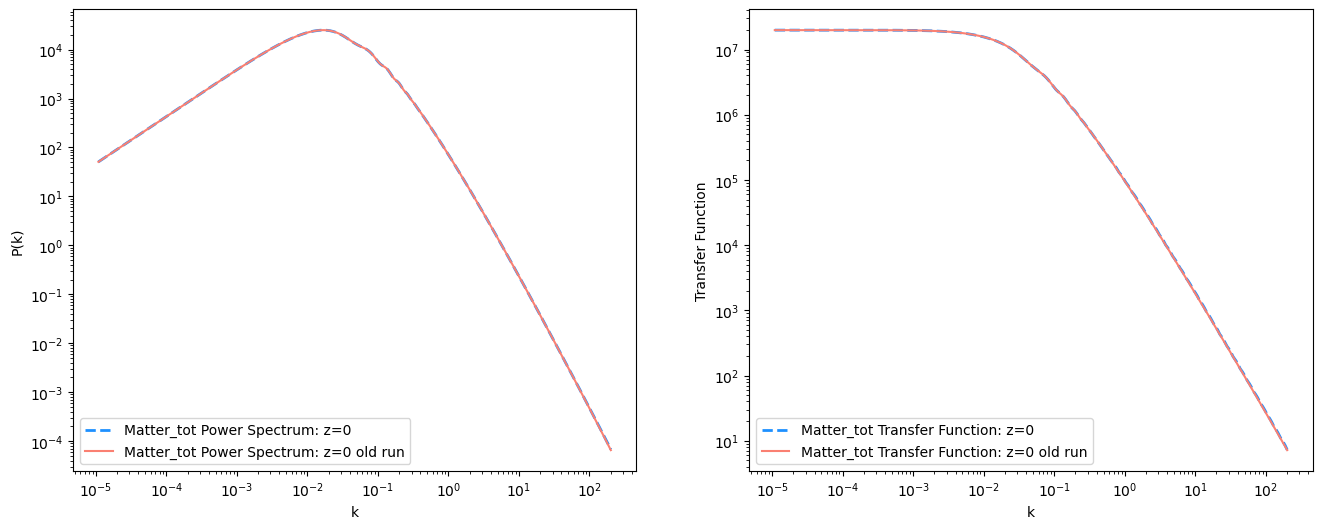

In [10]:
# Load matter power spectrum and transfer function data
k_arr_pk, pk_z = np.loadtxt('CAMB_PK_Tables_and_Transfer_function/camb_pk_149.dat', unpack=True)
k_arr_transfer, transfer_interpolated_cdm, transfer_interpolated_bar, transfer_interpolated_phot, transfer_interpolated_neu,  transfer_interpolated_nu, transfer_interpolated_tot = np.loadtxt('CAMB_PK_Tables_and_Transfer_function/camb_transfer_149.dat', unpack=True)

# OLD RUN with neutrinos test
k_arr_pk_old, pk_z_old = np.loadtxt('/u/mlepinzan/PINOCCHIO/PINOCCHIO_testing_phase/READ_PK_TABLE_and_SCALE_DEP/Neutrino_run_test/CAMB/lcdm_planck/lcdm_matterpower_149.dat', unpack=True)
old_transfer           = np.loadtxt('/u/mlepinzan/PINOCCHIO/PINOCCHIO_testing_phase/READ_PK_TABLE_and_SCALE_DEP/Neutrino_run_test/CAMB/lcdm_planck/lcdm_transfer_out_149.dat', unpack=True)
k_arr_transfer_old     = old_transfer[0]
transfer_value_old_cdm = old_transfer[1]
transfer_value_old_bar = old_transfer[2]
transfer_value_old_tot = old_transfer[6]

# Create figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# Plot matter power spectrum
axs[0].plot(k_arr_pk, pk_z, c='dodgerblue', ls='--', lw=2, label='Matter_tot Power Spectrum: z=0')
axs[0].plot(k_arr_pk_old , pk_z_old , c='salmon', ls='-', lw=1.5, label='Matter_tot Power Spectrum: z=0 old run')
axs[0].set_xlabel('k')
axs[0].set_ylabel('P(k)')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend()

# Plot transfer function
axs[1].plot(k_arr_transfer, transfer_interpolated_cdm, ls='--', c='dodgerblue', lw=2, label='Matter_tot Transfer Function: z=0')
axs[1].plot(k_arr_transfer_old, transfer_value_old_cdm, c='salmon',ls='-', lw=1.5, label='Matter_tot Transfer Function: z=0 old run')
axs[1].set_xlabel('k')
axs[1].set_ylabel('Transfer Function')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].legend()

plt.savefig("PK_and_Transfer_Functio_z_0.png")
plt.show()

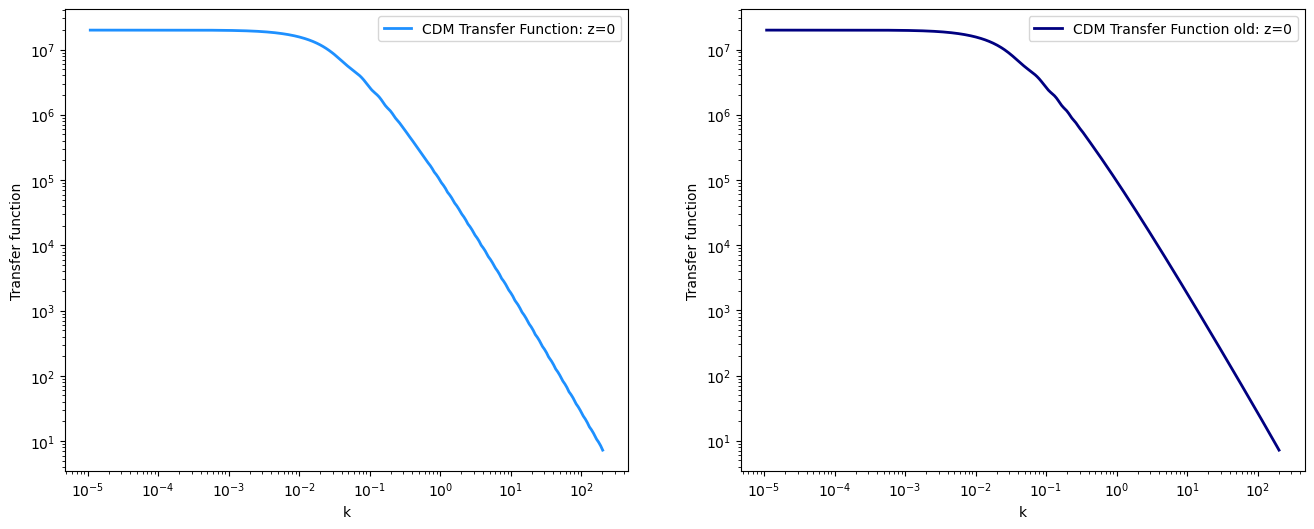

In [16]:
# DIFFERENT trasnfer functions: cdm, baryon and tot. New run vs old run
# Create figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# Plot new run transfer functions
axs[0].plot(k_arr_transfer, transfer_interpolated_cdm, ls='-', c='dodgerblue', lw=2, label='CDM Transfer Function: z=0')
# axs[0].plot(k_arr_transfer, transfer_interpolated_bar, ls='--', c='salmon', lw=2, label='BARYON Transfer Function: z=0')
# axs[0].plot(k_arr_transfer, transfer_interpolated_tot, ls='--', c='fuchsia', lw=2, label='TOT Transfer Function: z=0')
axs[0].set_xlabel('k')
axs[0].set_ylabel('Transfer function')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend()

# Plot old run transfer functions
axs[1].plot(k_arr_transfer_old, transfer_value_old_cdm, ls='-', c='navy', lw=2, label='CDM Transfer Function old: z=0')
# axs[1].plot(k_arr_transfer_old, transfer_value_old_bar, ls='--', c='salmon', lw=2, label='BARYON Transfer Function old: z=0')
# axs[1].plot(k_arr_transfer_old, transfer_value_old_tot, ls='-', c='red', lw=2, label='TOT Transfer Function old: z=0')
axs[1].set_xlabel('k')
axs[1].set_ylabel('Transfer function')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].legend()

# plt.savefig("PK_and_Transfer_Functio_z_0.png")
plt.show()

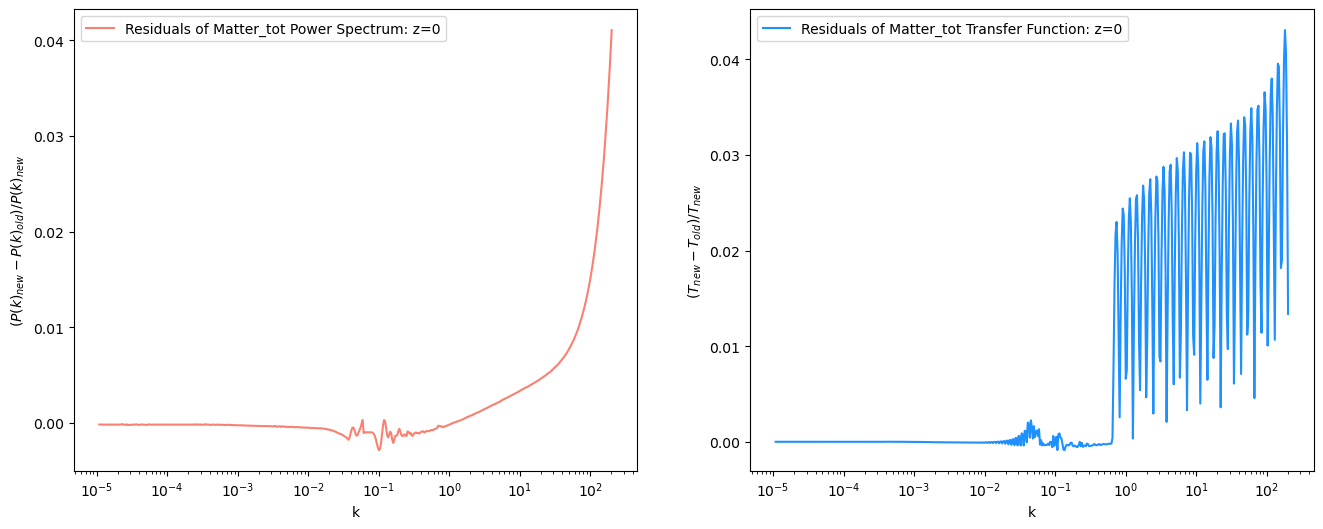

In [11]:
# Plot of residuals

fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# Plot matter power spectrum
axs[0].plot(k_arr_pk, (pk_z - pk_z_old)/pk_z, c='salmon', label='Residuals of Matter_tot Power Spectrum: z=0')
axs[0].set_xlabel('k')
axs[0].set_ylabel('($P(k)_{new} - P(k)_{old})/P(k)_{new}$')
axs[0].set_xscale('log')
# axs[0].set_yscale('log')
axs[0].legend()

# Plot transfer function
axs[1].plot(k_arr_transfer, (transfer_interpolated_cdm - transfer_value_old_cdm)/transfer_interpolated_cdm, c='dodgerblue', label='Residuals of Matter_tot Transfer Function: z=0')
axs[1].set_xlabel('k')
axs[1].set_ylabel('$(T_{new} - T_{old})/T_{new}$')
axs[1].set_xscale('log')
# axs[1].set_yscale('log')
axs[1].legend()

plt.savefig("PK_and_Transfer_Functio_z_0_residuals.png")
plt.show()

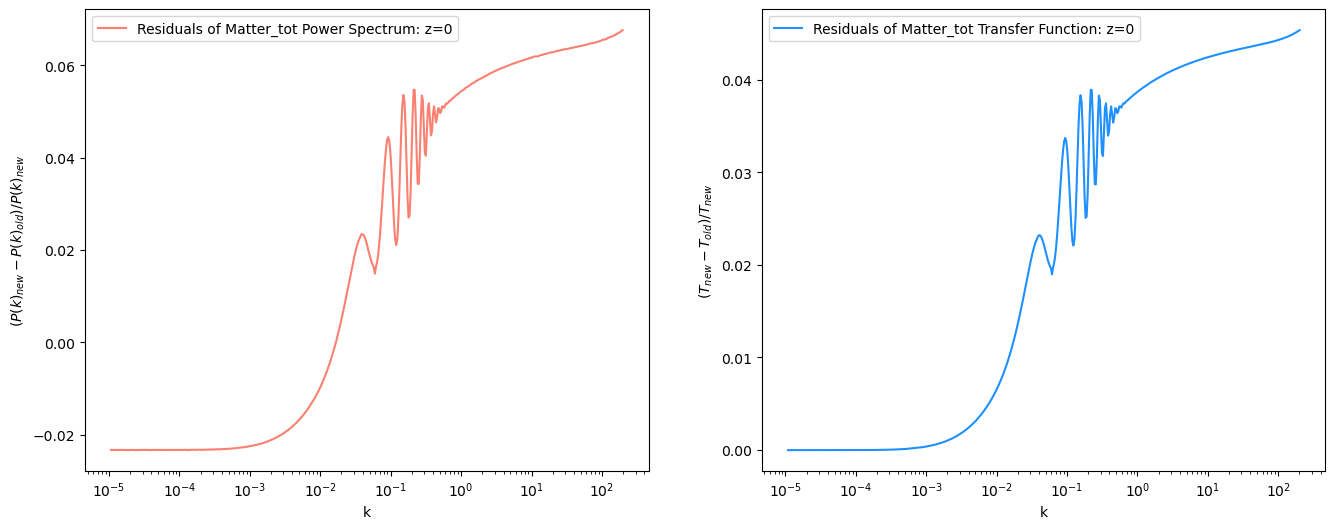

In [23]:
############################### TESTS #################################################################
k_arr_pk_test, pk_z_test    = np.loadtxt('/u/mlepinzan/PINOCCHIO/PINOCCHIO_testing_phase/READ_PK_TABLE_and_SCALE_DEP/test/lcdm_matterpower_149.dat', unpack=True)
old_transfer_test           = np.loadtxt('/u/mlepinzan/PINOCCHIO/PINOCCHIO_testing_phase/READ_PK_TABLE_and_SCALE_DEP/test/lcdm_transfer_out_149.dat', unpack=True)
k_arr_transfer_test         = old_transfer_test[0]
transfer_value_old_cdm_test = old_transfer_test[1]
transfer_value_old_bar_test = old_transfer_test[2]
transfer_value_old_tot_test = old_transfer_test[6]

##########################################################################################################################

# OLD RUN with neutrinos test
k_arr_pk_old, pk_z_old = np.loadtxt('/u/mlepinzan/PINOCCHIO/PINOCCHIO_testing_phase/READ_PK_TABLE_and_SCALE_DEP/Neutrino_run_test/CAMB/lcdm_planck/lcdm_matterpower_149.dat', unpack=True)
old_transfer           = np.loadtxt('/u/mlepinzan/PINOCCHIO/PINOCCHIO_testing_phase/READ_PK_TABLE_and_SCALE_DEP/Neutrino_run_test/CAMB/lcdm_planck/lcdm_transfer_out_149.dat', unpack=True)
k_arr_transfer_old     = old_transfer[0]
transfer_value_old_cdm = old_transfer[1]
transfer_value_old_bar = old_transfer[2]
transfer_value_old_tot = old_transfer[6]

interpolator_pk_test       = interp1d(k_arr_pk_old, pk_z_old , kind='linear', fill_value='extrapolate')
interpolator_transfer_test = interp1d(k_arr_transfer_old ,transfer_value_old_cdm  , kind='linear', fill_value='extrapolate')

interpolated_test_pk       = interpolator_pk_test(k_arr_pk_test)
interpolated_test_transfer = interpolator_transfer_test(k_arr_transfer_test)


fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# Plot matter power spectrum
axs[0].plot(k_arr_pk_test, (interpolated_test_pk - pk_z_old)/interpolated_test_pk, c='salmon', label='Residuals of Matter_tot Power Spectrum: z=0')
axs[0].set_xlabel('k')
axs[0].set_ylabel('($P(k)_{new} - P(k)_{old})/P(k)_{new}$')
axs[0].set_xscale('log')
# axs[0].set_yscale('log')
axs[0].legend()

# Plot transfer function
axs[1].plot(k_arr_transfer_old, (interpolated_test_transfer - transfer_value_old_cdm)/interpolated_test_transfer, c='dodgerblue', label='Residuals of Matter_tot Transfer Function: z=0')
axs[1].set_xlabel('k')
axs[1].set_ylabel('$(T_{new} - T_{old})/T_{new}$')
axs[1].set_xscale('log')
# axs[1].set_yscale('log')
axs[1].legend()

plt.savefig("test.png")
plt.show()
